In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150

## summary

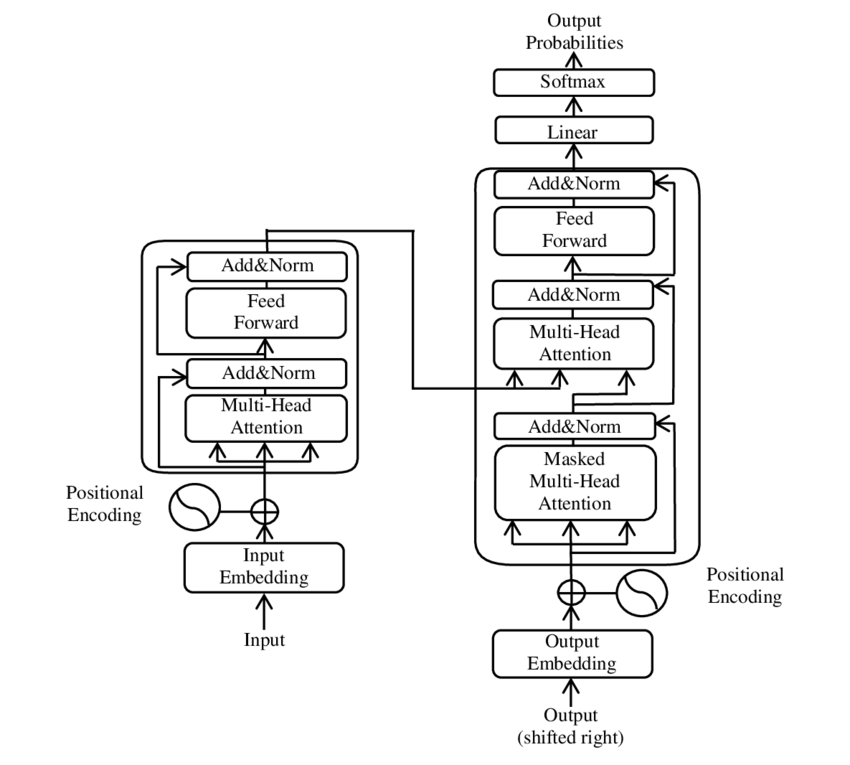

In [2]:
Image('../imgs/The-Transformer-model-architecture.png')

- decoder 与 encoder 相比，有两个特殊的 attention sublayers
    - masked multi-head (**self**) attention
    - encoder-decoder (**cross**) attention
        - (k, v) from encoder （memory, last encoder layer）
        - q：decoder input
    - 两者权值不共享

##  mask

In [3]:
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
# print(model)
# print(model.embeddings)
# print(model.encoder)
# 只显示了 layer 的定义，层与层之间的拓扑/连接关系，在 module 的 forward 中定义；
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# input
# config.vocab_size: 30522, 
# config.hidden_size: 768=64*12
# lookup-table, learnable
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
# token_embedding
sample_text = 'time flies like an arrow'
model_inputs = tokenizer(sample_text, return_tensors='pt', add_special_tokens=False)
# forward of embedding module
input_embeddings = token_embedding(model_inputs['input_ids'])
# batch_size, seq_len, hidden_size
input_embeddings.shape

torch.Size([1, 5, 768])

### 下三角矩阵

In [6]:
import math
q = k = v = input_embeddings
# (1, 5, 768) * (1, 768, 5) => (1, 5, 5)
scores = torch.bmm(q, k.transpose(1, 2))/math.sqrt(k.size(-1))
scores

tensor([[[29.3773,  1.3381, -0.1734, -1.9150, -0.0372],
         [ 1.3381, 29.0873, -0.4198, -0.8163,  0.1404],
         [-0.1734, -0.4198, 29.4697, -1.8265,  0.3513],
         [-1.9150, -0.8163, -1.8265, 25.6442, -0.4334],
         [-0.0372,  0.1404,  0.3513, -0.4334, 27.0381]]],
       grad_fn=<DivBackward0>)

In [7]:
seq_len = model_inputs['input_ids'].size(-1)
# triangular lower（上三角的话，torch.triu，upper triangular）
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print(mask.shape)
mask

torch.Size([1, 5, 5])


tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

In [8]:
scores.masked_fill(mask == 0, -float('inf'))

tensor([[[29.3773,    -inf,    -inf,    -inf,    -inf],
         [ 1.3381, 29.0873,    -inf,    -inf,    -inf],
         [-0.1734, -0.4198, 29.4697,    -inf,    -inf],
         [-1.9150, -0.8163, -1.8265, 25.6442,    -inf],
         [-0.0372,  0.1404,  0.3513, -0.4334, 27.0381]]],
       grad_fn=<MaskedFillBackward0>)

In [9]:
# in place
scores.masked_fill_(mask == 0, -float('inf'))

tensor([[[29.3773,    -inf,    -inf,    -inf,    -inf],
         [ 1.3381, 29.0873,    -inf,    -inf,    -inf],
         [-0.1734, -0.4198, 29.4697,    -inf,    -inf],
         [-1.9150, -0.8163, -1.8265, 25.6442,    -inf],
         [-0.0372,  0.1404,  0.3513, -0.4334, 27.0381]]],
       grad_fn=<MaskedFillBackward0>)

In [10]:
scores

tensor([[[29.3773,    -inf,    -inf,    -inf,    -inf],
         [ 1.3381, 29.0873,    -inf,    -inf,    -inf],
         [-0.1734, -0.4198, 29.4697,    -inf,    -inf],
         [-1.9150, -0.8163, -1.8265, 25.6442,    -inf],
         [-0.0372,  0.1404,  0.3513, -0.4334, 27.0381]]],
       grad_fn=<MaskedFillBackward0>)

$$
\exp(-\infty) = 0
$$

In [11]:
torch.exp(torch.tensor(-float('inf')))

tensor(0.)

## (masked) self attention

In [12]:
def scaled_dot_product_attn(q, k, v, mask=None):
    # q, k, v: (b, s, h/a) (a: number heads, 12, 768/12=64)
    dim_k = k.size(-1)
    # b, s, s
    scores = torch.bmm(q, k.transpose(1, 2))/math.sqrt(dim_k)
    if mask is not None:
        scores.masked_fill_(mask == 0, -float('inf'))
    # 上对角值为 0 
    attn_weights = F.softmax(scores, dim=-1)
    print(attn_weights)
    return torch.bmm(attn_weights, v)

In [13]:
scaled_dot_product_attn(q, k, v, mask)

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [8.8860e-13, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3371e-13, 1.0452e-13, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0745e-12, 3.2234e-12, 1.1738e-12, 1.0000e+00, 0.0000e+00],
         [1.7432e-12, 2.0818e-12, 2.5706e-12, 1.1729e-12, 1.0000e+00]]],
       grad_fn=<SoftmaxBackward0>)


tensor([[[-0.4962, -0.8516, -1.3029,  ...,  1.6259, -0.9577, -1.2302],
         [ 0.5159,  2.1284,  0.5108,  ...,  0.9423, -1.8939, -0.1485],
         [ 1.3011, -1.3183, -0.5242,  ..., -1.0556, -1.9022, -1.6921],
         [-0.3695, -0.8165, -1.8978,  ...,  0.0317,  1.2554, -0.1684],
         [-0.0618,  0.3547, -0.0952,  ..., -1.1292, -0.3383,  0.4696]]],
       grad_fn=<BmmBackward0>)

## 源码分析

In [14]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
# s1, b, h1
# from encoder output (last encoder layer output)
memory = torch.rand(10, 32, 512)
# s2, b, h2, from decoder input
tgt = torch.rand(20, 32, 512)

In [15]:
print(decoder_layer.dropout.training)
print(decoder_layer.dropout1.training)
print(decoder_layer.dropout2.training)
print(decoder_layer.dropout3.training)

True
True
True
True


In [16]:
# bn, dropout
decoder_layer.eval()

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

In [17]:
print(decoder_layer.dropout.training)
print(decoder_layer.dropout1.training)
print(decoder_layer.dropout2.training)
print(decoder_layer.dropout3.training)

False
False
False
False


In [21]:
out = decoder_layer(tgt, memory)
print(out.shape)
out

torch.Size([20, 32, 512])


tensor([[[-1.8008,  0.0955,  0.4715,  ..., -0.8585,  1.3289, -0.8393],
         [-0.9372,  0.3635,  0.5085,  ..., -1.6473,  0.3759,  1.4563],
         [-0.6191,  0.0879,  0.6518,  ..., -0.2662, -0.5986, -0.1011],
         ...,
         [-0.7244,  0.2882, -0.6515,  ..., -0.3170,  0.3018,  1.0053],
         [-0.7184,  0.9173,  0.2708,  ..., -1.1280,  0.7655,  0.5195],
         [-0.1449,  1.3841, -1.6920,  ..., -1.5435,  0.8277,  1.8407]],

        [[ 0.0512,  0.6386, -0.0195,  ..., -0.2089,  2.6903,  1.4809],
         [ 0.4438, -0.0604, -0.5986,  ...,  0.0636,  1.2456, -0.1515],
         [-0.2601, -1.1402, -1.0853,  ...,  0.1306,  1.2988,  1.3415],
         ...,
         [ 0.7709,  0.1656, -1.2257,  ..., -0.8002, -0.0339,  2.0337],
         [-1.1068, -0.9135,  0.7009,  ...,  0.4307,  0.7334,  1.4293],
         [-1.7199,  1.5007,  0.3761,  ..., -1.8088,  1.7812,  0.2291]],

        [[-0.1397, -0.4083, -0.9826,  ..., -1.3970,  1.2486,  0.2054],
         [-1.0634, -0.6352, -0.2336,  ..., -1

In [22]:
# multi head, masked multi head self attn
def self_attn(x):
    x = decoder_layer.self_attn(x, x, x)[0]
    return decoder_layer.dropout1(x)
# multi head, multi head attn
def cross_attn(q, k, v=None):
    if v is None:
        v = k
    x = decoder_layer.multihead_attn(q, k, v)[0]
    return decoder_layer.dropout2(x)
def ffn(x):
    # h => 4h (512, 2048)
    x = decoder_layer.dropout(F.relu(decoder_layer.linear1(x)))
    # 4h => h (2048, 512)
    x = decoder_layer.linear2(x)
    return x

In [23]:
print(self_attn(tgt).shape)
print(cross_attn(tgt, memory, memory).shape)
print(ffn(tgt).shape)

torch.Size([20, 32, 512])
torch.Size([20, 32, 512])
torch.Size([20, 32, 512])


In [24]:
# https://arxiv.org/pdf/2002.04745v1.pdf
def decoder_forward(tgt, memory, norm_first=False):
    x = tgt
    if norm_first:
        x = x + self_attn(decoder_layer.norm1(x))
        x = x + cross_attn(decoder_layer.norm2(x), memory)
        x = x + ffn(decoder_layer.norm3(x))
    else:
        x = decoder_layer.norm1(x + self_attn(x))
        x = decoder_layer.norm2(x + cross_attn(x, memory))
        x = decoder_layer.norm3(x + ffn(x))
    return x

In [25]:
decoder_forward(tgt, memory)

tensor([[[-1.8008,  0.0955,  0.4715,  ..., -0.8585,  1.3289, -0.8393],
         [-0.9372,  0.3635,  0.5085,  ..., -1.6473,  0.3759,  1.4563],
         [-0.6191,  0.0879,  0.6518,  ..., -0.2662, -0.5986, -0.1011],
         ...,
         [-0.7245,  0.2882, -0.6515,  ..., -0.3170,  0.3018,  1.0053],
         [-0.7184,  0.9173,  0.2708,  ..., -1.1280,  0.7655,  0.5195],
         [-0.1449,  1.3841, -1.6920,  ..., -1.5435,  0.8277,  1.8407]],

        [[ 0.0512,  0.6386, -0.0195,  ..., -0.2089,  2.6903,  1.4809],
         [ 0.4438, -0.0604, -0.5986,  ...,  0.0636,  1.2456, -0.1515],
         [-0.2601, -1.1402, -1.0853,  ...,  0.1306,  1.2988,  1.3415],
         ...,
         [ 0.7709,  0.1656, -1.2257,  ..., -0.8002, -0.0339,  2.0337],
         [-1.1068, -0.9135,  0.7009,  ...,  0.4307,  0.7334,  1.4293],
         [-1.7199,  1.5007,  0.3761,  ..., -1.8088,  1.7812,  0.2291]],

        [[-0.1397, -0.4083, -0.9826,  ..., -1.3970,  1.2486,  0.2054],
         [-1.0634, -0.6352, -0.2336,  ..., -1